In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

In [17]:
# Load dataset
(ds_train, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
class_names = ds_info.features['label'].names
print("Classes:", class_names)

Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']


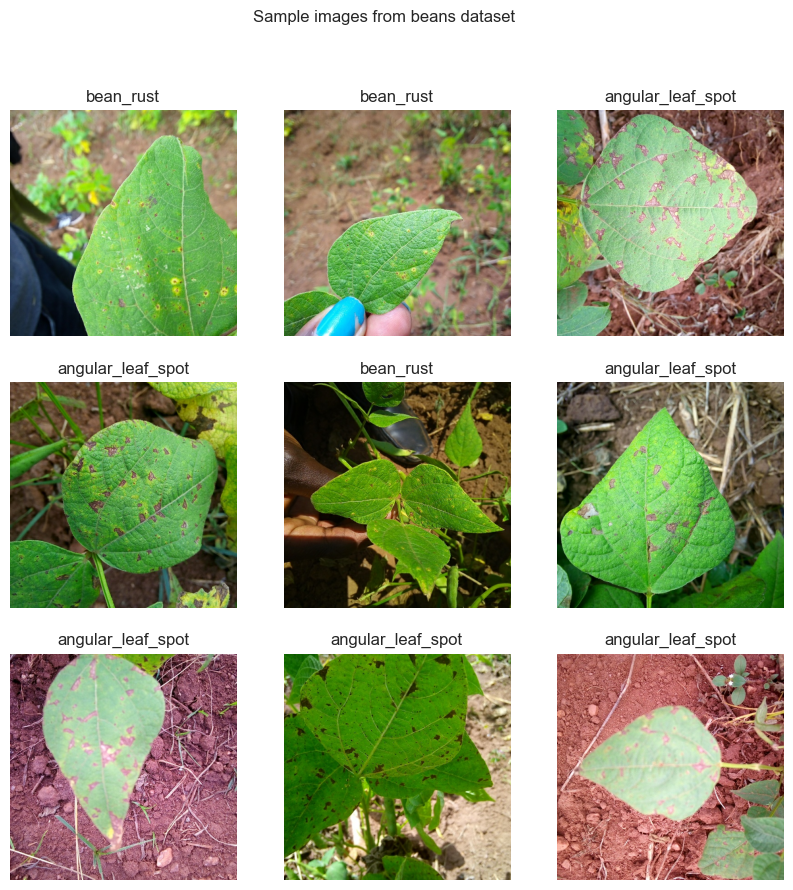

In [18]:
# Visualize sample data
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis("off")
plt.suptitle("Sample images from beans dataset")
plt.show()

In [19]:
IMG_SIZE = 128
BATCH_SIZE = 16

# Data augmentation for CNN
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.2),
])



In [20]:
# Preprocessing for CNN (keeps spatial structure)
def preprocess_cnn(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label
# Prepare CNN data
ds_train_cnn = ds_train.map(preprocess_cnn, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_cnn = ds_test.map(preprocess_cnn, num_parallel_calls=tf.data.AUTOTUNE)

# Split training data into train/validation
train_size = len(list(ds_train_cnn))
val_size = int(0.2 * train_size)
train_size = train_size - val_size

# CNN data splits
ds_train_cnn_shuffled = ds_train_cnn.shuffle(1000, seed=42)
ds_val_cnn = ds_train_cnn_shuffled.take(val_size)
ds_train_cnn = ds_train_cnn_shuffled.skip(val_size)
# Batch and cache dataset
ds_train_cnn = ds_train_cnn.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
ds_val_cnn = ds_val_cnn.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
ds_test_cnn = ds_test_cnn.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {len(list(ds_test))}")



Training set size: 828
Validation set size: 206
Test set size: 128


In [21]:
# CONVOLUTIONAL MODEL
print("Creating Convolutional Model...")
cnn_model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation,
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')
])

Creating Convolutional Model...


In [22]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

# Train Convolutional Model
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
print("Training Convolutional Model...")
cnn_history = cnn_model.fit(ds_train_cnn,
                            validation_data=ds_val_cnn,
                            epochs=30,
                            callbacks=[early_stop, reduce_lr],
                            verbose=1)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,235,107 (12.34 MB)

 Trainable params: 3,235,107 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

Training Convolutional Model...
Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.3805 - loss: 1.0989 - val_accuracy: 0.4612 - val_loss: 1.0221 - learning_rate: 1.0000e-04
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.4856 - loss: 1.0181 - val_accuracy: 0.5825 - val_loss: 0.9054 - learning_rate: 1.0000e-04
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.5583 - loss: 0.9437 - val_accuracy: 0.6893 - val_loss: 0.7752 - learning_rate: 1.0000e-04
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.5903 - loss: 0.8718 - val_accuracy: 0.7330 - val_loss: 0.7275 - learning_rate: 1.0000e-04
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.6070 - loss: 0.8182 - val_accuracy: 0.7621 - val_loss: 0.6894 - learning_rate: 1.0000e-04
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.6728 - loss: 0.7710 - val_accuracy: 0.7718 - val_loss: 0.6707 - learning_rate: 1.0000e-04
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 

In [23]:

# Preprocessing for FC (flattens image)
def preprocess_fc(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [-1])  # Flatten to 1D
    return image, label

# Prepare FC data
ds_train_fc = ds_train.map(preprocess_fc, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_fc = ds_test.map(preprocess_fc, num_parallel_calls=tf.data.AUTOTUNE)

# Split training data into train/validation
train_size = len(list(ds_train_fc))
val_size = int(0.2 * train_size)
train_size = train_size - val_size

# FC data splits
ds_train_fc_shuffled = ds_train_fc.shuffle(1000, seed=42)
ds_val_fc = ds_train_fc_shuffled.take(val_size)
ds_train_fc = ds_train_fc_shuffled.skip(val_size)

ds_train_fc = ds_train_fc.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
ds_val_fc = ds_val_fc.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
ds_test_fc = ds_test_fc.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {len(list(ds_test))}")



Training set size: 828
Validation set size: 206
Test set size: 128


In [24]:
# FULLY CONNECTED MODEL
print("Creating Fully Connected Model...")
fc_model = models.Sequential([
    layers.Input(shape=(IMG_SIZE * IMG_SIZE * 3,)),  # Flattened input
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])


Creating Fully Connected Model...


In [25]:
fc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

fc_model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,339,011 (96.66 MB)

 Trainable params: 25,339,011 (96.66 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train Fully Connected Model
print("Training Fully Connected Model...")
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(patience=3, factor=0.5)

fc_history = fc_model.fit(ds_train_fc,
                          validation_data=ds_val_fc,
                          epochs=30,
                          callbacks=[early_stop, reduce_lr],
                          verbose=1)

Training Fully Connected Model...
Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.3636 - loss: 2.1138 - val_accuracy: 0.2913 - val_loss: 1.5344 - learning_rate: 1.0000e-04
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.3583 - loss: 1.5502 - val_accuracy: 0.5485 - val_loss: 1.0377 - learning_rate: 1.0000e-04
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.3616 - loss: 1.1877 - val_accuracy: 0.5388 - val_loss: 0.9954 - learning_rate: 1.0000e-04
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.4194 - loss: 1.0706 - val_accuracy: 0.5777 - val_loss: 1.0321 - learning_rate: 1.0000e-04
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 0.3818 - loss: 1.1174 - val_accuracy: 0.3204 - val_loss: 1.1055 - learning_rate: 1.0000e-04
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.3227 - loss: 1.1082 - val_accuracy: 0.2379 - val_loss: 1.0988 - learning_rate: 1.0000e-04
Epoch 7/30
52/52 ━━━━━━━━━━

Plotting training histories...


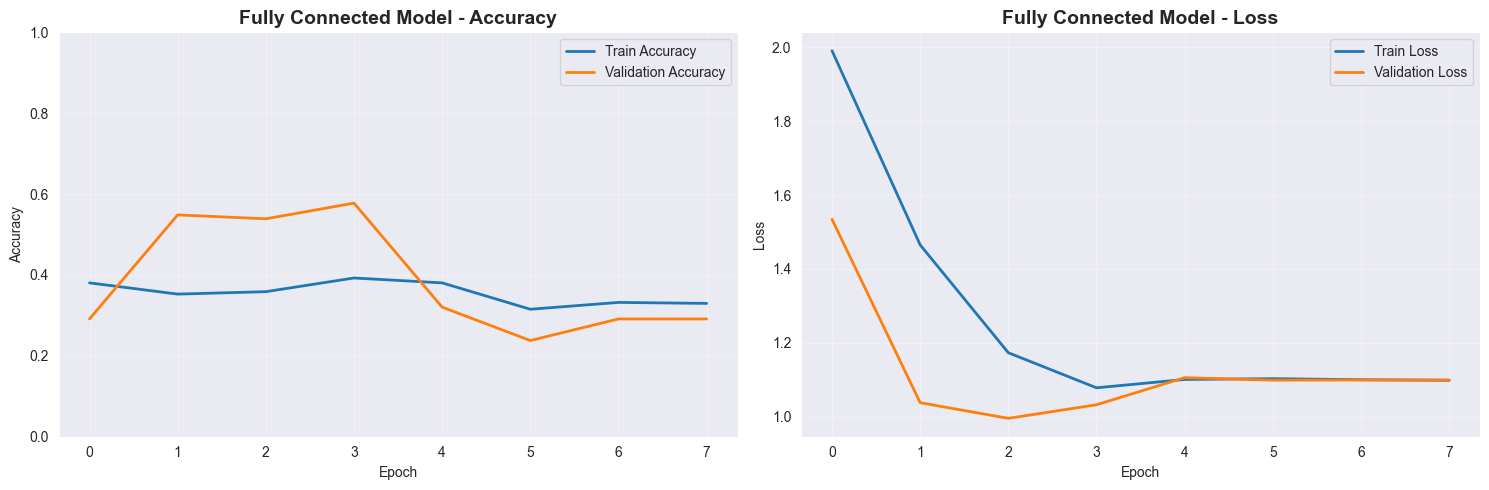

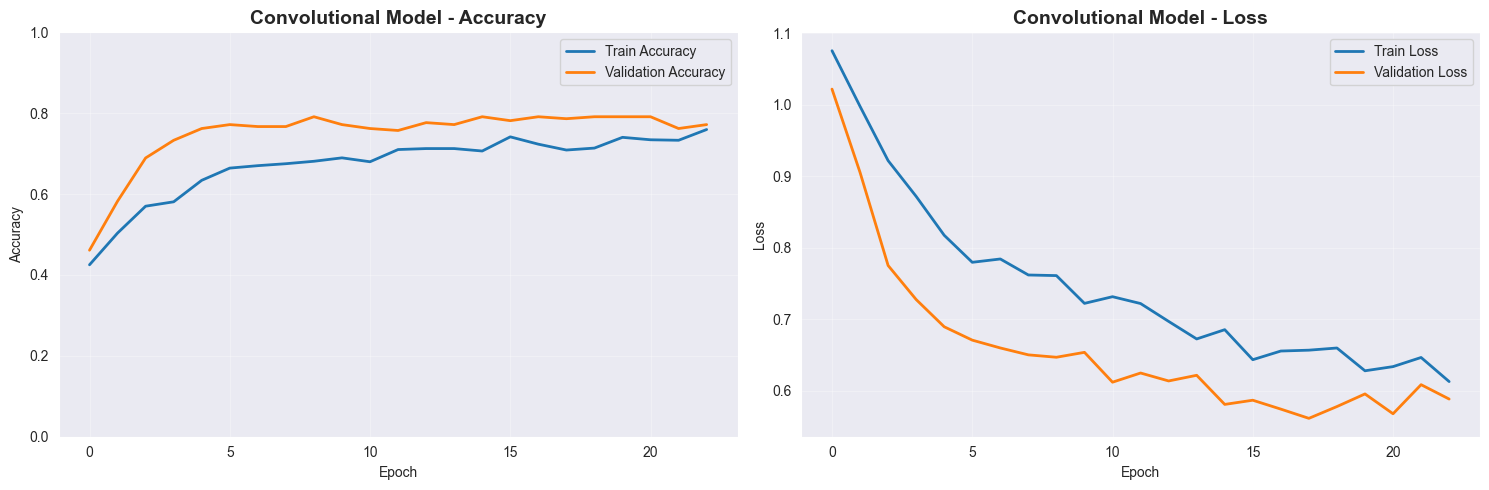

In [34]:

# Plot training histories
def plot_training_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title(f'{title} - Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # Loss plot
    ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
print("Plotting training histories...")
plot_training_history(fc_history, "Fully Connected Model")
plot_training_history(cnn_history, "Convolutional Model")


In [35]:
# Evaluate both models on test data
print("Evaluating models on test data...")
fc_test_results = fc_model.evaluate(ds_test_fc, verbose=1)
print(f"FC Test Accuracy: {fc_test_results[1]:.4f}")
print(f"FC Test Loss: {fc_test_results[0]:.4f}")

cnn_test_results = cnn_model.evaluate(ds_test_cnn, verbose=1)
print(f"CNN Test Accuracy: {cnn_test_results[1]:.4f}")
print(f"CNN Test Loss: {cnn_test_results[0]:.4f}")

# Model comparison summary
print("\n" + "=" * 50)
print("MODEL COMPARISON SUMMARY")
print("=" * 50)
print(f"Fully Connected Model:")
print(f"  Parameters: {fc_model.count_params():,}")
print(f"  Test Accuracy: {fc_test_results[1]:.4f}")
print(f"  Best Val Accuracy: {max(fc_history.history['val_accuracy']):.4f}")

print(f"\nConvolutional Model:")
print(f"  Parameters: {cnn_model.count_params():,}")
print(f"  Test Accuracy: {cnn_test_results[1]:.4f}")
print(f"  Best Val Accuracy: {max(cnn_history.history['val_accuracy']):.4f}")

improvement = (cnn_test_results[1] - fc_test_results[1]) * 100
print(f"\nCNN Improvement: {improvement:.2f}% better than FC")
print("=" * 50)

Evaluating models on test data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5219 - loss: 1.0395
FC Test Accuracy: 0.5234
FC Test Loss: 1.0337
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8109 - loss: 0.6146
CNN Test Accuracy: 0.8047
CNN Test Loss: 0.5562

MODEL COMPARISON SUMMARY
Fully Connected Model:
  Parameters: 25,339,011
  Test Accuracy: 0.5234
  Best Val Accuracy: 0.5777

Convolutional Model:
  Parameters: 3,235,107
  Test Accuracy: 0.8047
  Best Val Accuracy: 0.7913

CNN Improvement: 28.12% better than FC


Visualizing CNN predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


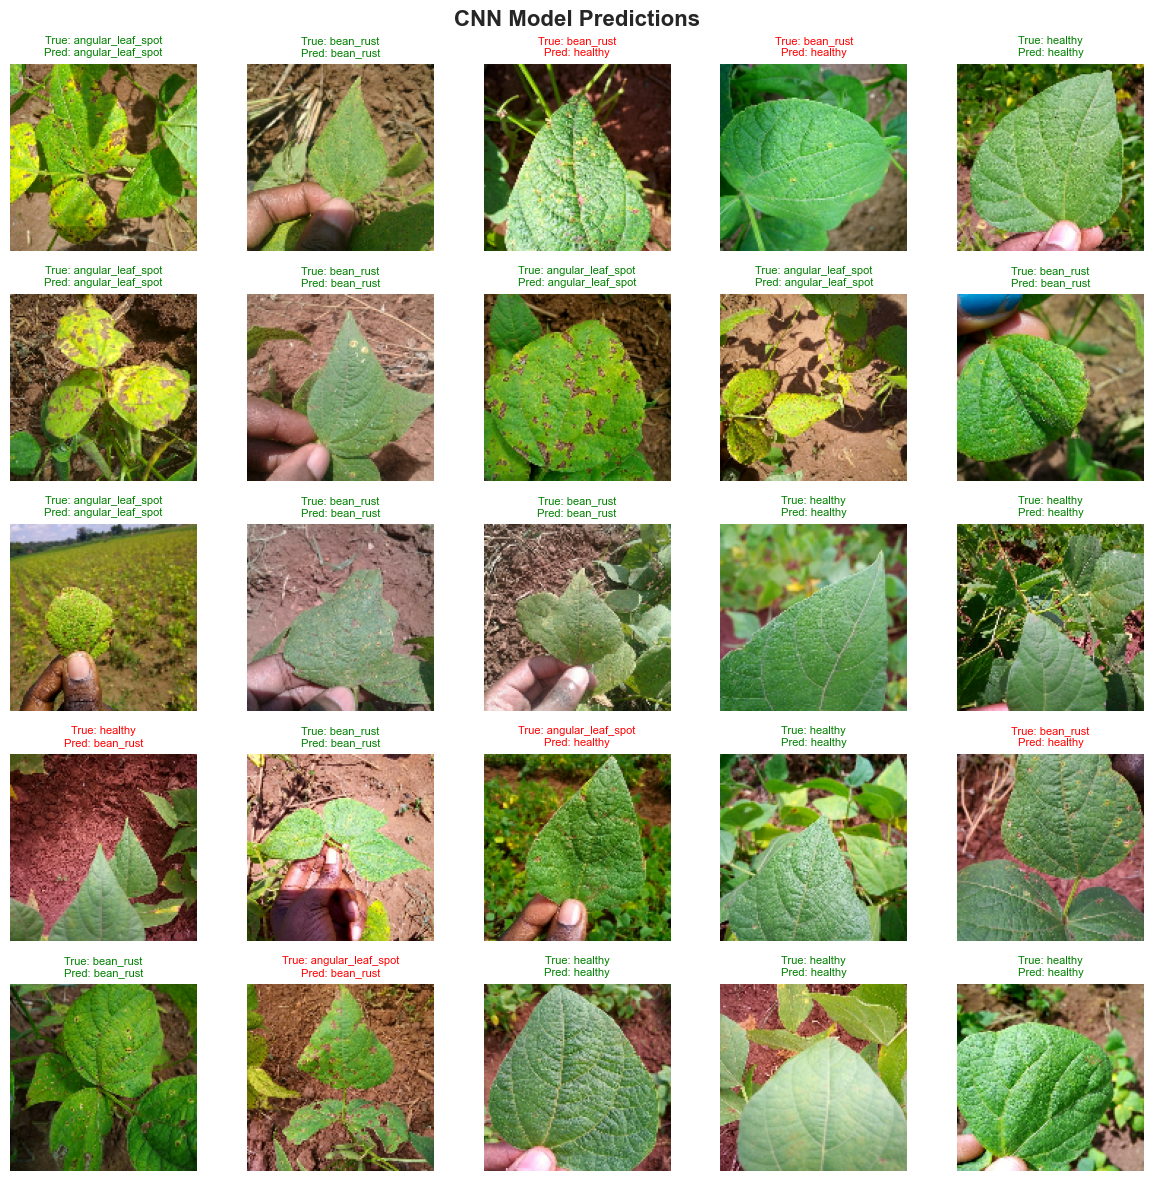

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


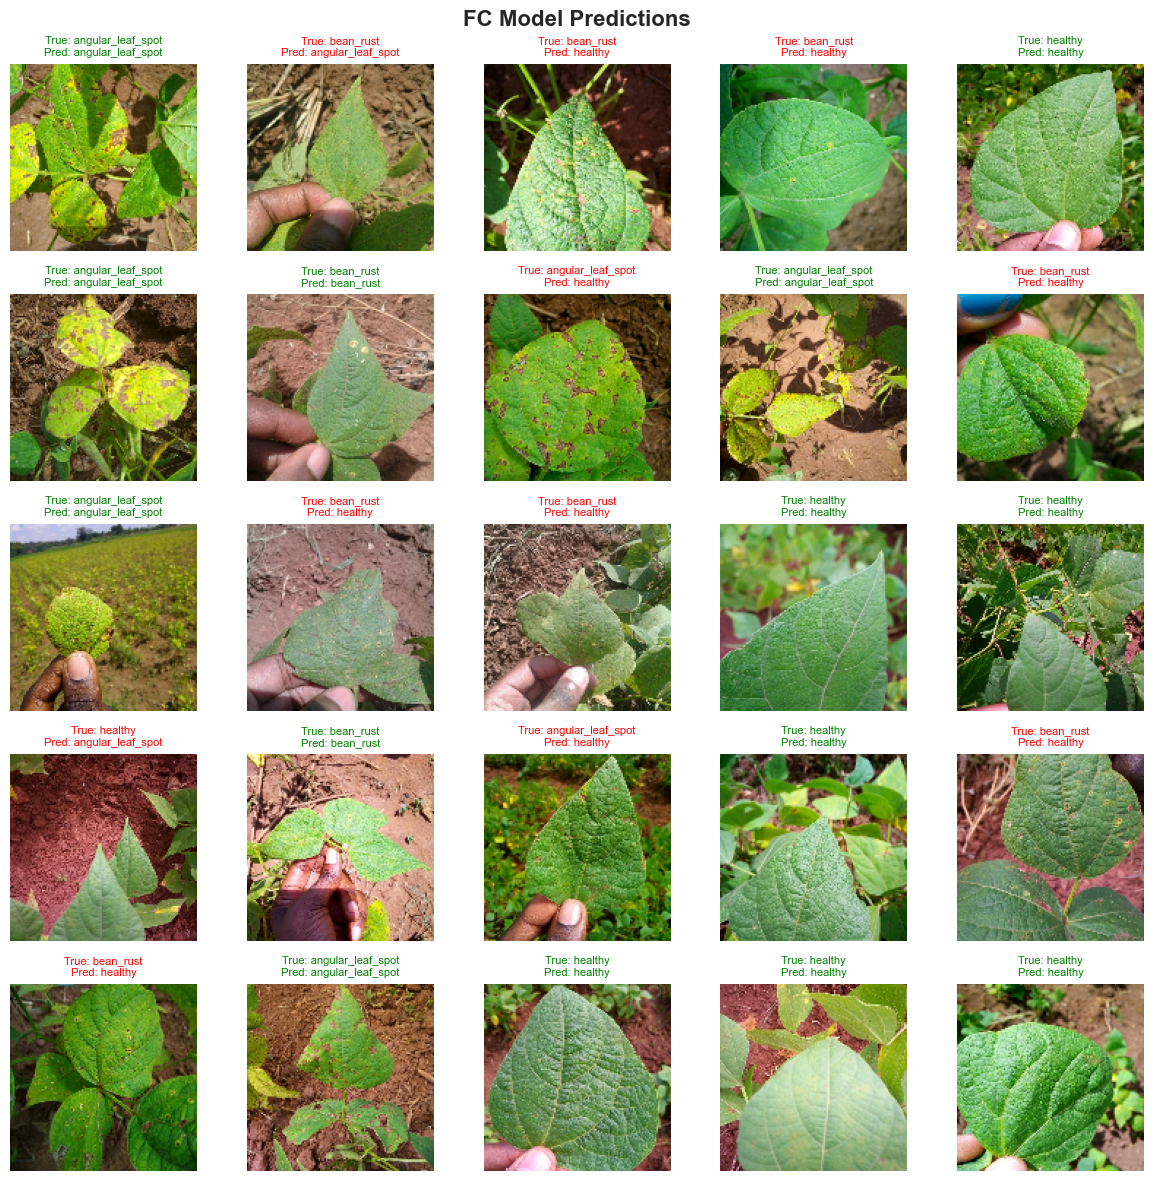

In [29]:

def visualize_predictions(model, dataset, title, num_samples=25):
    x_test = []
    y_test = []

    for x, y in dataset.unbatch().take(num_samples):
        x_test.append(x)
        y_test.append(y)

    x_test = tf.stack(x_test)
    y_test = tf.stack(y_test)

    preds = model.predict(x_test)
    pred_labels = tf.argmax(preds, axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        ax = plt.subplot(5, 5, i + 1)
        if x_test[i].shape.rank == 1:  # For flattened images (FC)
            image = tf.reshape(x_test[i], (IMG_SIZE, IMG_SIZE, 3))
        else:
            image = x_test[i]
        plt.imshow(image)
        true_label = class_names[y_test[i].numpy()]
        predicted_label = class_names[pred_labels[i].numpy()]
        color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color, fontsize=8)
        plt.axis("off")
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


print("Visualizing CNN predictions...")
visualize_predictions(cnn_model, ds_test_cnn, "CNN Model Predictions")
visualize_predictions(fc_model, ds_test_fc, "FC Model Predictions")



Creating confusion matrix for CNN model...


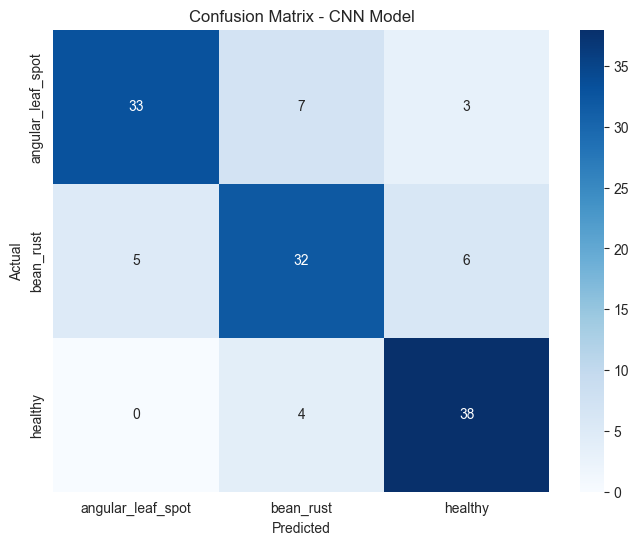

Creating confusion matrix for CNN model...


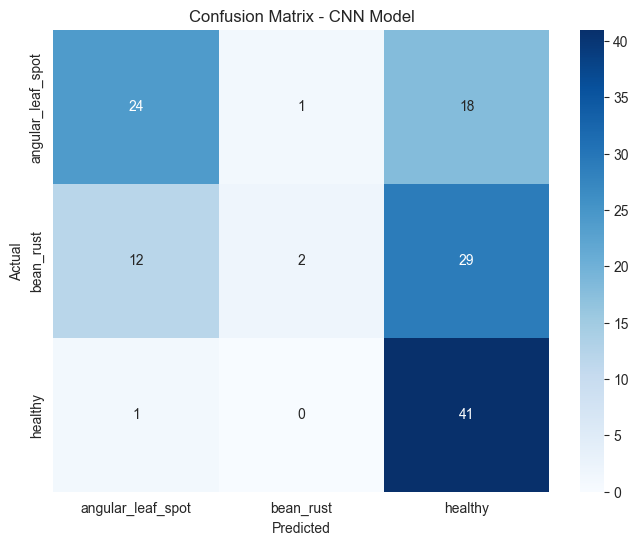

In [30]:
# Create confusion matrix for CNN model
def plot_confusion_matrix(model, dataset, class_names):
    y_true = []
    y_pred = []

    for x, y in dataset:
        predictions = model.predict(x, verbose=0)
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())
        y_true.extend(y.numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - CNN Model')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return cm


print("Creating confusion matrix for CNN model...")
cm = plot_confusion_matrix(cnn_model, ds_test_cnn, class_names)

print("Creating confusion matrix for CNN model...")
cm1 = plot_confusion_matrix(fc_model, ds_test_fc, class_names)


In [32]:

# Calculate per-class metrics
def calculate_metrics(cm, class_names):
    precision = []
    recall = []
    f1_score = []

    for i in range(len(class_names)):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

        precision.append(prec)
        recall.append(rec)
        f1_score.append(f1)

    print("-" * 40)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:15} | Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f} | F1: {f1_score[i]:.3f}")

    print(f"\nMacro averages:")
    print(f"Precision: {np.mean(precision):.3f}")
    print(f"Recall: {np.mean(recall):.3f}")
    print(f"F1-Score: {np.mean(f1_score):.3f}")

print("\nPer-class metrics (CNN Model):")
calculate_metrics(cm, class_names)
print("\nPer-class metrics (FC Model):")
calculate_metrics(cm1, class_names)


Per-class metrics (CNN Model):
----------------------------------------
angular_leaf_spot | Precision: 0.868 | Recall: 0.767 | F1: 0.815
bean_rust       | Precision: 0.744 | Recall: 0.744 | F1: 0.744
healthy         | Precision: 0.809 | Recall: 0.905 | F1: 0.854

Macro averages:
Precision: 0.807
Recall: 0.805
F1-Score: 0.804

Per-class metrics (FC Model):
----------------------------------------
angular_leaf_spot | Precision: 0.649 | Recall: 0.558 | F1: 0.600
bean_rust       | Precision: 0.667 | Recall: 0.047 | F1: 0.087
healthy         | Precision: 0.466 | Recall: 0.976 | F1: 0.631

Macro averages:
Precision: 0.594
Recall: 0.527
F1-Score: 0.439
